# ALUMNO: Ezequiel Scordamaglia

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [48]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [49]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('.\data\clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = '.\data\clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [50]:
# Armar el dataset
df = pd.read_csv('.\data\clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [51]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [52]:
df_reviews.shape

(22641, 2)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: xlabel='Rating', ylabel='count'>

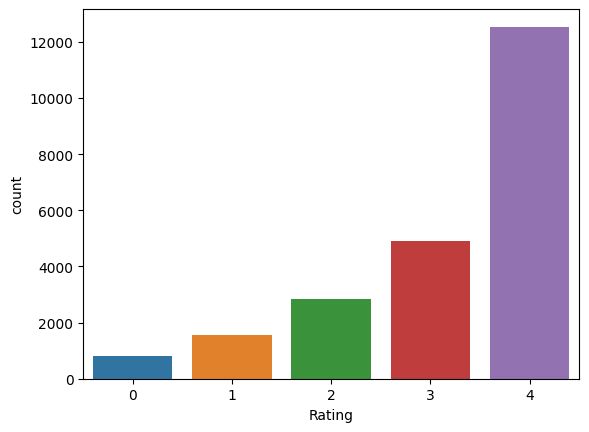

In [53]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
sns.countplot(x='Rating', data=df_reviews)

In [54]:
# Unificar clases 0 y 1 en una sola clase 0
df_reviews['Rating'] = df_reviews['Rating'].replace(1, 0)

# Unificar clases 2 y 3 en una sola clase 1
df_reviews['Rating'] = df_reviews['Rating'].replace([2, 3], 1)

# Renombrar a clase 4 por clase 2
df_reviews['Rating'] = df_reviews['Rating'].replace(4, 2)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: xlabel='Rating', ylabel='count'>

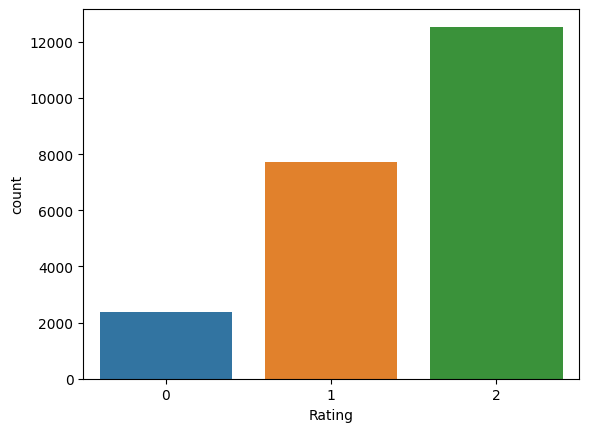

In [55]:
sns.countplot(x='Rating', data=df_reviews)

In [56]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EZEQUIEL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### NLPAUG para aumentar los datos alterando palabras con sinonimos

In [57]:
# Use nlpaug.augmenter para aumentar los datos de la clase minoritaria
from nltk.corpus import wordnet
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

aug = naw.SynonymAug(aug_src='wordnet', aug_max=10)

# Crear un nuevo vector de reviews aumentadas
reviews_aug_0 = []

# Recorrer el vector de df_reviews
for index, review in df_reviews.iterrows():
    if (review['Rating'] == 0):
        # Aumentar la cantidad de reviews de la clase 0
        # print("Original:", review['Review Text'])
        
        # Generar un numero aleatorio entre 2 y 3
        palabras_a_generar = random.randint(2, 3)

        augmented_text = aug.augment(review['Review Text'], n=palabras_a_generar)
        # print("Augmented Text:", augmented_text)
        for i in range(0, palabras_a_generar):
            reviews_aug_0.append(augmented_text[i])

# Crear un nuevo dataframe con las reviews aumentadas
df_reviews_aug_0 = pd.DataFrame(reviews_aug_0, columns=['Review Text'])
df_reviews_aug_0['Rating'] = 0
df_reviews_aug = pd.concat([df_reviews, df_reviews_aug_0], ignore_index=True)


d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: xlabel='Rating', ylabel='count'>

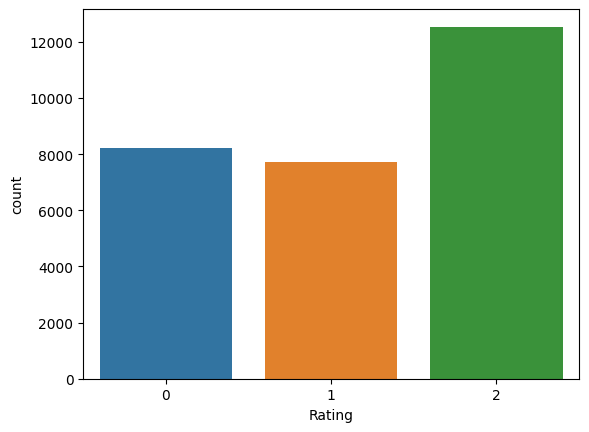

In [58]:
sns.countplot(x='Rating', data=df_reviews_aug)

In [59]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews_aug['Review Text'].values


In [60]:
reviews

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       ...,
       'This dress is so cute in the photo and set true to size, but the stuff is slinky and fe

In [61]:
# Cuantas reviews (rows) hay para evaluar?
reviews.shape

(28508,)

In [62]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)


In [63]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

9016999

In [64]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [65]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [66]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

1755593

In [67]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

# Definir el Tokenizer
tok = Tokenizer(num_words = num_words)

# Ajustar el Tokenizer al corpus
tok.fit_on_texts(tokens)

In [68]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 17547
{1: 'the', 2: 'i', 3: 'and', 4: 'it', 5: 'a', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'on', 12: 'of', 13: 'for', 14: 'was', 15: 'with', 16: 'so', 17: 'my', 18: 'dress', 19: 'not', 20: 'that', 21: 'size', 22: 'be', 23: 'very', 24: 'have', 25: 'love', 26: 'like', 27: 'top', 28: 'fit', 29: 'are', 30: 'as', 31: 'me', 32: 'too', 33: "'", 34: 'wear', 35: 'just', 36: 'would', 37: 'am', 38: 'great', 39: 'or', 40: 'you', 41: 'at', 42: "it's", 43: 'they', 44: 'fabric', 45: 'up', 46: "i'm", 47: 'small', 48: 'color', 49: 'look', 50: 'if', 51: 'really', 52: 'one', 53: 'ordered', 54: 'more', 55: 'back', 56: 'out', 57: 'these', 58: 'an', 59: 'had', 60: 'will', 61: 'little', 62: 'all', 63: 'well', 64: 'when', 65: 'flattering', 66: 'perfect', 67: 'because', 68: 'shirt', 69: 'than', 70: 'material', 71: 'looks', 72: 'cute', 73: 'soft', 74: 'can', 75: 'much', 76: 'beautiful', 77: 'large', 78: 'which', 79: 'nice', 80: 'them', 81: 'also', 82: 'bought', 83: 'down', 

In [69]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews)

In [70]:
sequences[:20]

[[267, 572, 1012, 3, 786, 3, 84],
 [25,
  7,
  18,
  42,
  1649,
  105,
  2,
  1216,
  8,
  236,
  4,
  9,
  5,
  122,
  3,
  46,
  364,
  2,
  130,
  1235,
  2,
  429,
  36,
  24,
  53,
  4,
  133,
  1235,
  42,
  98,
  2,
  82,
  5,
  98,
  3,
  37,
  586,
  2,
  25,
  1,
  89,
  11,
  31,
  453,
  35,
  5,
  61,
  456,
  1,
  430,
  36,
  179,
  22,
  5,
  148,
  1564,
  11,
  394,
  422,
  6,
  712,
  98],
 [2,
  59,
  303,
  185,
  892,
  13,
  7,
  18,
  3,
  51,
  171,
  4,
  8,
  102,
  13,
  31,
  2,
  1272,
  53,
  1,
  98,
  47,
  17,
  252,
  21,
  10,
  2,
  233,
  7,
  8,
  22,
  47,
  16,
  47,
  9,
  664,
  20,
  2,
  111,
  19,
  713,
  4,
  45,
  2,
  4,
  9,
  98,
  103,
  78,
  14,
  35,
  674,
  245,
  1,
  27,
  591,
  14,
  84,
  3,
  28,
  283,
  10,
  1,
  178,
  591,
  59,
  5,
  23,
  150,
  270,
  482,
  3,
  529,
  730,
  340,
  159,
  1066,
  5,
  1924,
  143,
  1546,
  14,
  1,
  159,
  482,
  762,
  312,
  1,
  431,
  4,
  680],
 [2,
  25,
  25,
  25,
  

In [71]:
# Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

maxlen = max(seqs_lenght)

el máximo es 595


(array([8.000e+00, 1.100e+01, 1.800e+01, 2.300e+01, 2.800e+01, 3.900e+01,
        7.600e+01, 1.430e+02, 1.480e+02, 1.800e+02, 2.420e+02, 2.010e+02,
        2.220e+02, 2.550e+02, 2.010e+02, 2.740e+02, 2.620e+02, 2.680e+02,
        2.890e+02, 3.160e+02, 3.050e+02, 2.610e+02, 3.350e+02, 2.980e+02,
        3.550e+02, 3.400e+02, 3.820e+02, 3.630e+02, 2.880e+02, 3.610e+02,
        4.000e+02, 3.440e+02, 3.940e+02, 3.910e+02, 4.100e+02, 3.180e+02,
        4.200e+02, 3.980e+02, 3.640e+02, 3.830e+02, 3.620e+02, 3.720e+02,
        2.930e+02, 4.300e+02, 3.970e+02, 3.620e+02, 3.270e+02, 3.520e+02,
        3.170e+02, 2.880e+02, 3.560e+02, 3.520e+02, 3.220e+02, 3.300e+02,
        3.260e+02, 3.170e+02, 2.800e+02, 2.730e+02, 3.190e+02, 2.950e+02,
        3.100e+02, 2.970e+02, 2.930e+02, 2.960e+02, 2.300e+02, 2.830e+02,
        2.750e+02, 2.610e+02, 2.620e+02, 2.400e+02, 2.270e+02, 2.050e+02,
        2.180e+02, 2.440e+02, 2.470e+02, 2.030e+02, 2.030e+02, 1.960e+02,
        1.780e+02, 1.920e+02, 2.160e+0

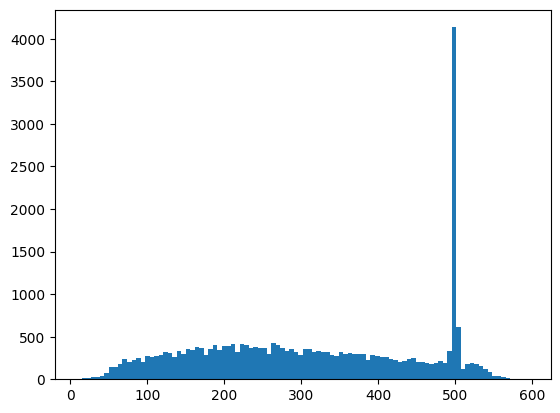

In [72]:
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [73]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
# maxlen = 585
# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [74]:
# Observar las dimensiones de la variable input
X.shape


(28508, 595)

In [75]:
# qué porcentaje de los datos se procesan completamente
(np.array(seqs_lenght)<maxlen).mean()

0.9999649221271222

In [76]:
# tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 3)
y = to_categorical(df_reviews_aug['Rating'].values, num_classes=3)
print(y.shape)

(28508, 3)


In [77]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_reviews_aug['Rating'].values)

### BALANCEO DEL DATASET

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

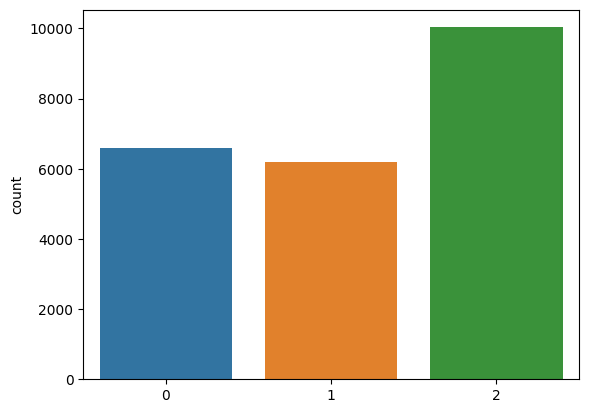

In [78]:
# Ver countplot de los datos de train
y_train_aux = np.argmax(y_train, axis=1)
sns.countplot(x=y_train_aux)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

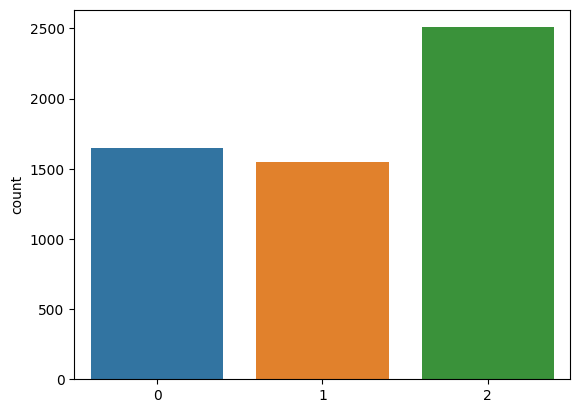

In [79]:
y_test_aux = np.argmax(y_test, axis=1)
sns.countplot(x=y_test_aux)

In [80]:
# Cantidad de elementos de la clase 0 en train
train_len_0 = len(y_train_aux[y_train_aux == 0])

# Cantidad de elementos de la clase 0 en test
test_len_0 = len(y_test_aux[y_test_aux == 0])

print(f'Cantidad de elementos de la clase 0 en train: {train_len_0}')
print(f'Cantidad de elementos de la clase 0 en test: {test_len_0}')


Cantidad de elementos de la clase 0 en train: 6589
Cantidad de elementos de la clase 0 en test: 1648


### OVERSAMPLING

In [81]:
# # Hacer oversampling de la clase 0 y 1 para balancear el dataset con SMOTE
# from imblearn.over_sampling import SMOTE
# sm_train = SMOTE(random_state=42, sampling_strategy={0: 6000})
# X_train, y_train = sm_train.fit_resample(X_train, y_train)

# sm_test = SMOTE(random_state=42, sampling_strategy={0: 1500})
# X_test, y_test = sm_test.fit_resample(X_test, y_test)

In [82]:
# Hacer oversampling de la clase 0 y 1 para balancear el dataset con RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
ros_train = RandomOverSampler(random_state=42, sampling_strategy={1: train_len_0})
X_train, y_train = ros_train.fit_resample(X_train, y_train)

# ros_test = RandomOverSampler(random_state=42, sampling_strategy={1: test_len_0})
# X_test, y_test = ros_test.fit_resample(X_test, y_test)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

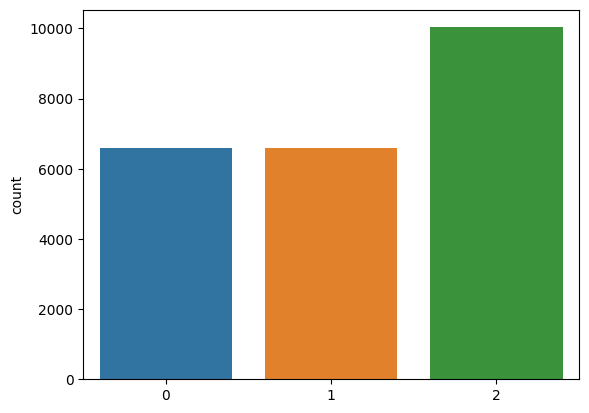

In [83]:
# Ver countplot de los datos de train
y_train_aux = np.argmax(y_train, axis=1)
sns.countplot(x=y_train_aux)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

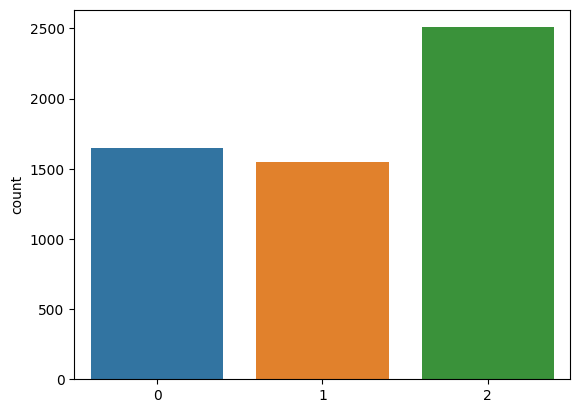

In [84]:
y_test_aux = np.argmax(y_test, axis=1)
sns.countplot(x=y_test_aux)

### UNDERSAMPLING


In [85]:
# Hacer undersampling de la clase 2 para balancear el dataset
from imblearn.under_sampling import RandomUnderSampler
rus_train = RandomUnderSampler(random_state=42, sampling_strategy={1: train_len_0, 2: train_len_0})
X_train, y_train = rus_train.fit_resample(X_train, y_train)

# rus_test = RandomUnderSampler(random_state=42, sampling_strategy={1: test_len_0, 2: test_len_0})
# X_test, y_test = rus_test.fit_resample(X_train, y_test)


d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

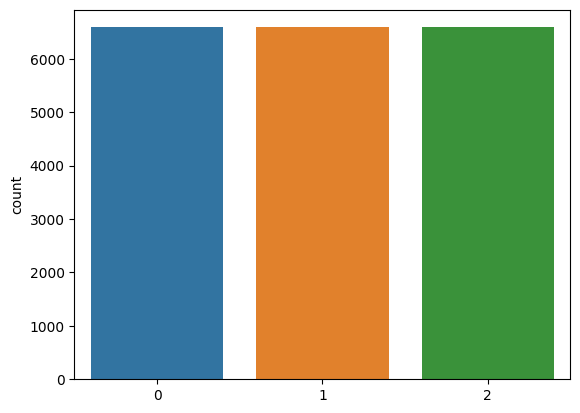

In [86]:
# Ver countplot de los datos de train
y_train_aux = np.argmax(y_train, axis=1)
sns.countplot(x=y_train_aux)

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

<Axes: ylabel='count'>

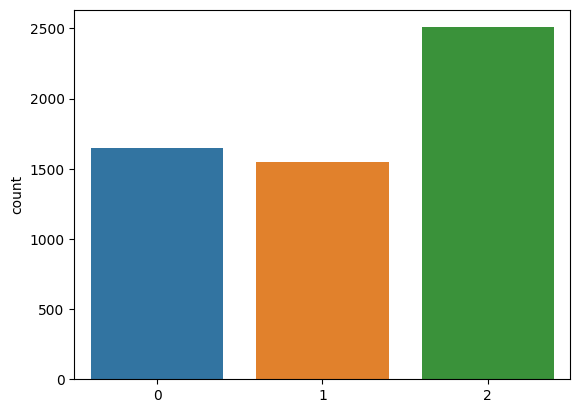

In [87]:
y_test_aux = np.argmax(y_test, axis=1)
sns.countplot(x=y_test_aux)

In [88]:
# determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 3 # number of classes
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 595 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [89]:
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

#### 2.1 - Entrenando mis propios embeddings

In [90]:
from keras import backend as K
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='softmax'))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer="adam",
              loss='categorical_crossentropy', # categorical_crossentropy para clasificación multiclase
              metrics=['accuracy',f1_m,precision_m, recall_m]) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 595, 100)          200100    
                                                                 
 lstm_6 (LSTM)               (None, 595, 128)          117248    
                                                                 
 dropout_6 (Dropout)         (None, 595, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [91]:
hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
618/618 [==============================] - 810s 1s/step - loss: 0.6817 - accuracy: 0.6640 - f1_m: 0.6116 - precision_m: 0.6950 - recall_m: 0.5626 - val_loss: 0.5640 - val_accuracy: 0.7531 - val_f1_m: 0.7488 - val_precision_m: 0.7762 - val_recall_m: 0.7240
Epoch 2/20
618/618 [==============================] - 781s 1s/step - loss: 0.5362 - accuracy: 0.7536 - f1_m: 0.7474 - precision_m: 0.7681 - recall_m: 0.7285 - val_loss: 0.5318 - val_accuracy: 0.7673 - val_f1_m: 0.7634 - val_precision_m: 0.7807 - val_recall_m: 0.7473
Epoch 3/20
618/618 [==============================] - 775s 1s/step - loss: 0.4972 - accuracy: 0.7823 - f1_m: 0.7781 - precision_m: 0.7911 - recall_m: 0.7659 - val_loss: 0.5662 - val_accuracy: 0.7299 - val_f1_m: 0.7255 - val_precision_m: 0.7386 - val_recall_m: 0.7134
Epoch 4/20
618/618 [==============================] - 781s 1s/step - loss: 0.4724 - accuracy: 0.7928 - f1_m: 0.7910 - precision_m: 0.8017 - recall_m: 0.7809 - val_loss: 0.6230 - val_accuracy: 0.7168 

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

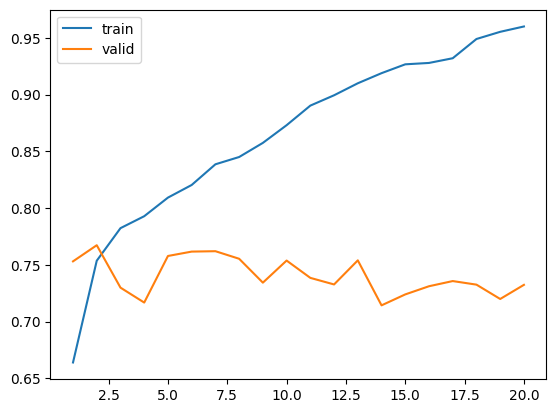

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [93]:
model.evaluate(X_test, y_test)

179/179 [==============================] - 55s 307ms/step - loss: 1.3386 - accuracy: 0.7324 - f1_m: 0.7322 - precision_m: 0.7328 - recall_m: 0.7316


[1.33856201171875,
 0.7323746085166931,
 0.7321785092353821,
 0.7328299283981323,
 0.7315526604652405]

In [95]:
# Ver la matriz de confusion del modelo como plot
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_aux = np.argmax(y_test, axis=1)

mat = confusion_matrix(y_test_aux, y_pred)
mat

179/179 [==============================] - 53s 297ms/step


array([[1423,  204,   21],
       [ 200,  861,  485],
       [  74,  542, 1892]], dtype=int64)

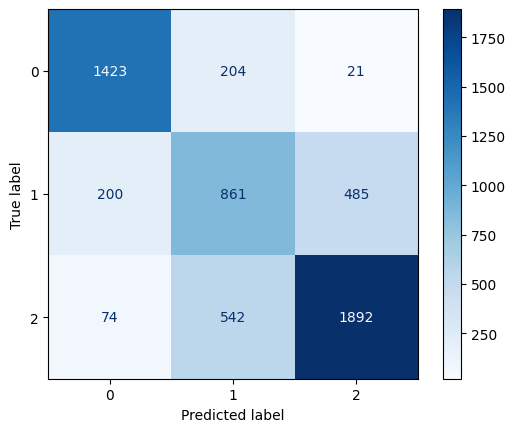

In [96]:
# Crear la visualización de la matriz de confusión
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = mat, display_labels = ['0', '1', '2'])

# Graficar la matriz de confusión
cm_display.plot(cmap='Blues')
plt.show()

### Resultado de entrenamientos

```python
# Entrenamiento Nº1 (256min - 20 epocas):

RandomOverSampling   Train +6000
RandomUnderSampling  Train -6000

accuracy: 0.7324

Matriz de confusion:
array([[1423,  204,   21],
       [ 200,  861,  485],
       [  74,  542, 1892]], dtype=int64)



```

#### 2.2 - Utilizando Embeddings pre-entrenados

In [97]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = './data/gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = './data/fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [98]:
model_fasttext = FasttextEmbeddings()

In [99]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [100]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 50 --> crear embeddings de tamaño 50
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy', # categorical_crossentropy para clasificación multiclase
              metrics=['acc',f1_m,precision_m, recall_m]) # F1-score para clasificación con datos desbalanceados

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 595, 300)          600000    
                                                                 
 lstm_8 (LSTM)               (None, 595, 64)           93440     
                                                                 
 dropout_8 (Dropout)         (None, 595, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                

In [101]:
hist2 = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
618/618 [==============================] - 537s 863ms/step - loss: 0.9471 - acc: 0.4878 - f1_m: 0.2611 - precision_m: 0.6533 - recall_m: 0.1728 - val_loss: 0.8569 - val_acc: 0.5368 - val_f1_m: 0.3638 - val_precision_m: 0.8463 - val_recall_m: 0.2360
Epoch 2/20
618/618 [==============================] - 485s 785ms/step - loss: 0.8431 - acc: 0.5658 - f1_m: 0.4433 - precision_m: 0.7195 - recall_m: 0.3292 - val_loss: 0.8201 - val_acc: 0.5987 - val_f1_m: 0.5113 - val_precision_m: 0.7513 - val_recall_m: 0.3919
Epoch 3/20
618/618 [==============================] - 505s 817ms/step - loss: 0.8095 - acc: 0.5943 - f1_m: 0.5021 - precision_m: 0.6972 - recall_m: 0.3994 - val_loss: 0.8106 - val_acc: 0.5605 - val_f1_m: 0.4727 - val_precision_m: 0.7084 - val_recall_m: 0.3587
Epoch 4/20
618/618 [==============================] - 631s 1s/step - loss: 0.7844 - acc: 0.6115 - f1_m: 0.5431 - precision_m: 0.6965 - recall_m: 0.4502 - val_loss: 0.7607 - val_acc: 0.6256 - val_f1_m: 0.5773 - val_precis

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

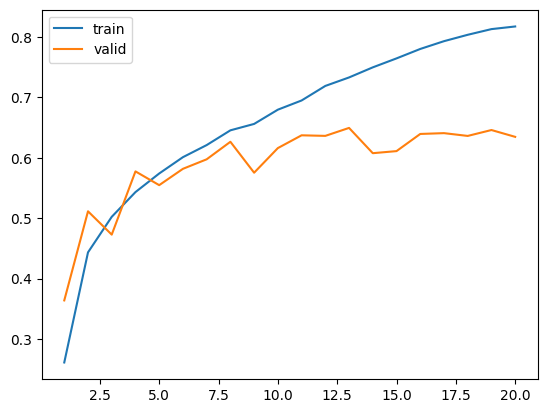

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['f1_m']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['f1_m'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_f1_m'], label='valid')
plt.show()

In [103]:
model2.evaluate(X_test, y_test)

179/179 [==============================] - 65s 362ms/step - loss: 0.9904 - acc: 0.6371 - f1_m: 0.6345 - precision_m: 0.6443 - recall_m: 0.6252


[0.9903975129127502,
 0.6371448636054993,
 0.6344681978225708,
 0.6443043947219849,
 0.6252327561378479]

In [104]:
y_pred2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)
y_test_aux2 = np.argmax(y_test, axis=1)

mat2 = confusion_matrix(y_test_aux2, y_pred)
mat2

179/179 [==============================] - 65s 356ms/step


array([[1423,  204,   21],
       [ 200,  861,  485],
       [  74,  542, 1892]], dtype=int64)

```python
# Entrenamiento Nº1 (196min - 20 epocas):

RandomOverSampling   Train +6000
RandomUnderSampling  Train -6000

accuracy: 0.6371

Matriz de confusion:
array([[1423,  204,   21],
       [ 200,  861,  485],
       [  74,  542, 1892]], dtype=int64)

```

### CONCLUSIÓN
En este Notebook se reducen las clases de salida de 5 clases a 3 clases, uniendo la primera con la segunda y la tercera con la cuatra.
Luego de dividir el dataset, se realizaron tareas de balanceo del dataset, con el objetivo de equilibrar la diferencia entre las clases.
Las tecnicas utilizadas fueron:
Oversampling -> nlpaug (Aumentar las muestras de la clase minoritaria copiando muestras y cambiando algunas palabras por sinonimos)
UnderSampling -> RandomUnderSampling (Eliminar muestras de la clase mayoritaria aleatoriamente)

Se entrenó el modelo para predecir las 3 clases usando el dataset balanceado, midiendo principalmente la metrica de Accuracy.

El modelo que entrnó sus propios embeddings con una dimension de 50 logró un Accuracy de 73.2 en validación, mientras que el modelo que utiliza los Embeddings pre-entrenados de fastext, logró un Accuracy de 63.7 en validación.

Si bien ambos modelos mejoraron su performance comparando con el notebook donde se realiza el OverSampling aleatorio o donde no se realiza ningun balanceo y se divide el dataset en 5 clases, se mantiene la idea de que utilizar Embeddings pre-entrenados para proposito general no ayuda a resolver el problema de analisis de sentimientos. El modelo que entrenó sus propios Embeddings logró un mejor Accuracy con respecto al que utilizó los Embeddings pre-entrenados.

La utilizacion de nlpaug para generar nuevas muestras de la clase minoritaria alterando los textos con palabras sinonimos, realmente genera un plus al momento de entrenar al modelo, quien puede entrenar muchos mejor teniendo muchas mas muestras de la clase minoritaria que no sean identicas a otras ya existentes.